In [46]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
import itertools
import qinfer as qi
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from lfig import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

In [82]:
save_directory = "/home/bf16951/thesis/theoretical_study/figures"
run_path = "Dec_10/16_12"
results = qmla.load_results(
    results_folder = "/home/bf16951/bc_results/",
    results_time = run_path,
)
q = results['qmla_instance']
es = results['exploration_strategy']
storage = results['storage']

gene_pool = es.genetic_algorithm.gene_pool
gene_pool.sort_values('f_score', inplace=True, ascending=False)
model_f_scores = q.model_f_scores
f_score_cmap = es.f_score_cmap

In [99]:
all_ratings = storage.exploration_strategy_storage.ratings

all_model_ratings_by_generation = pd.DataFrame()
models =sorted(all_ratings.model_id.unique())

for model in models:
    model_ratings = all_ratings[ all_ratings.model_id == model ]
    generations = model_ratings.generation.unique()

    for g in generations:
        mod_ratings_this_generation = model_ratings[model_ratings.generation == g]

        start_idx = mod_ratings_this_generation.idx.min()
        final_idx = mod_ratings_this_generation.idx.max()

        start_rating = all_ratings[
            (all_ratings.model_id == model)
            & (all_ratings.generation == g)
            & (all_ratings.idx == start_idx)
        ].rating.item()
        final_rating = all_ratings[
            (all_ratings.model_id == model)
            & (all_ratings.generation == g)
            & (all_ratings.idx == final_idx)
        ].rating.item()        

        new_data = [
            pd.Series({
                'model_id' : model, 
                'generation' : g, 
                'rating' : start_rating
            }),
            pd.Series({
                'model_id' : model, 
                'generation' : g+0.8, 
                'rating' : final_rating
            }),
        ]

        for d in new_data:
            all_model_ratings_by_generation = all_model_ratings_by_generation.append(
                d, ignore_index=True
            )


In [89]:
def gene_pool_progression(gene_pool, ax, draw_cbar=True, cbar_ax=None):
    num_models_per_generation = len(gene_pool[gene_pool.generation == 1])
    num_generations = gene_pool.generation.nunique()
    f_scores_of_gene_pool = np.empty((num_models_per_generation, num_generations))
    for g in gene_pool.generation.unique():

        f_scores_by_gen = gene_pool[
            gene_pool.generation == g
        ].f_score

        f_scores_of_gene_pool[:, g-1] = f_scores_by_gen

    sns.heatmap(
        f_scores_of_gene_pool,
        cmap = f_score_cmap,
        vmin = 0, 
        vmax=1,
        ax = ax,
        cbar=draw_cbar, 
        cbar_kws = dict(
            label=r"$F_1$-score",
            aspect=25, 
            ticks=[0,0.5,1],
        )
    )
    ax.set_yticks([])
    xtick_pos = range(5, num_generations+1, 5)
    ax.set_xticks([g-0.5 for g in xtick_pos])
    ax.set_xticklabels(
        xtick_pos
    )
    ax.set_xlabel('Generation')

    if cbar_ax is not None:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_ylabel(r"$F_1$", rotation=0, labelpad=10) # if F horizontal
        cbar.ax.yaxis.set_label_position("right", )
        cbar.ax.tick_params(labelleft=True, labelright=False )

In [100]:
def plot_elo_ratings(all_model_ratings_by_generation, ax, model_f_scores, max_gen_to_show=None):

    if max_gen_to_show is not None:
        # test a subset of generations for visibility
        all_model_ratings_by_generation = all_model_ratings_by_generation[
            all_model_ratings_by_generation.generation < 6
        ]

    # First prepare a dictionary to map model id to a colour corresponding to F-score
    f_granularity = 0.05
    available_f_scores = np.linspace(0, 1, 1 + (1/f_granularity) )

    model_coloured_by_f = {
        # m : colour_by_f[ qmla.utilities.round_nearest(f_scores[m], f_granularity) ]
        m : f_score_cmap(model_f_scores[m])
        for m in all_model_ratings_by_generation.model_id.unique()
    }

    # Plot
    sns.lineplot(
        x = 'generation', 
        y = 'rating', 
        hue = 'model_id', 
        data = all_model_ratings_by_generation, 
        palette=model_coloured_by_f,
        legend=False,
        ax = ax
    )
    for g in all_ratings.generation.unique():
        ax.axvline(g, ls='--', c='black')
    ax.set_xlabel('Generation',)
    ax.set_ylabel(
        r"$R$"
    )

    generations = list(all_model_ratings_by_generation.generation.astype(int).unique())
    for g in generations:
        xmin = g / (len(generations)-1)
        xmax = (g+1) / (len(generations)-1)
        init_rating = all_model_ratings_by_generation[
            all_model_ratings_by_generation.generation == g
        ].rating.median()

        ax.axhline(
            init_rating, 
            xmin=xmin, 
            xmax=xmax, 
            ls=':', 
            color='black'
        )

    ax.set_xticks(
        generations, 
    )
    ax.set_xlim(0, max(generations))



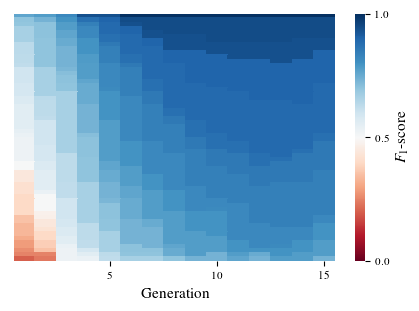

In [28]:
lf = LatexFigure(fraction=0.75, auto_label=False)
ax = lf.new_axis()
gene_pool_progression(gene_pool, ax)

# lf.save(
#     os.path.join(
#         save_directory, 
#         "gen_alg_instance.pdf"
#     )
# )


/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


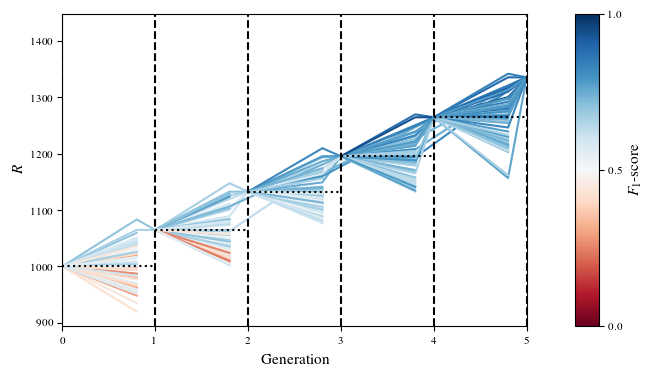

In [101]:

widths = [1, 0.05]

lf = LatexFigure(
    use_gridspec=True, 
    auto_label=False, 
    gridspec_layout=(1,len(widths)),
    gridspec_params = {
        'width_ratios' : widths,
    },
    legend_axis=(0,1)
)
ax = lf.new_axis()

plot_elo_ratings(
    all_model_ratings_by_generation = all_model_ratings_by_generation, 
    ax = ax, 
    model_f_scores = q.model_f_scores,
    max_gen_to_show = 4, 
)

cbar = mpl.colorbar.ColorbarBase(
    lf.legend_ax, 
    cmap = f_score_cmap,
    orientation="vertical",
    ticks=[0,0.5,1],
    label = r"$F_1$-score",
)

# lf.save(os.path.join(save_directory, 'elo_ratings_over_generations.pdf'))


/home/bf16951/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


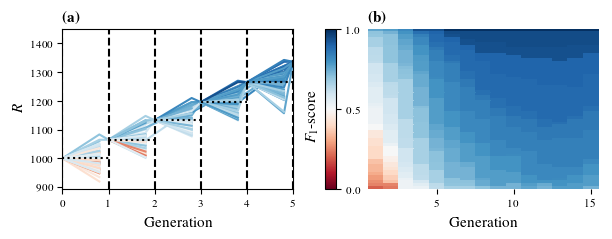

In [107]:
lf = LatexFigure(
    fraction=1, 
    use_gridspec=True, 
    auto_label=False, 
    gridspec_layout=(1,3),
    gridspec_params = {
        'width_ratios' : [1, 0.05, 1],
        'wspace' : 0.2, 
    },
    legend_axis=(0,1),
#     legend_span = ('all', 1)
)

ax = lf.new_axis(
    label=r"a"
)
plot_elo_ratings(
    all_model_ratings_by_generation = all_model_ratings_by_generation, 
    ax = ax, 
    model_f_scores = q.model_f_scores,
    max_gen_to_show = 4, 
)

cbar = mpl.colorbar.ColorbarBase(
    lf.legend_ax, 
    cmap = f_score_cmap,
    orientation="vertical",
    ticks=[0,0.5,1],
    label = r"$F_1$-score",
)
cbar.set_label(
    r"$F_1$-score",
    labelpad=-40, 
    y=0.45
)
ax = lf.new_axis(label=r"b")
gene_pool_progression(gene_pool, ax, draw_cbar=False,)
lf.save(os.path.join(save_directory, "gen_alg_instance_combined.pdf"))

In [ ]:
cbar.set_label()